# Material Balances VII

This lecture solves more Material Balance Example Problems

In [1]:
import numpy as np
from scipy.integrate import quadrature as quadgk
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.optimize as opt

## Example Problem 01

Consider the following gas-phase, irreversible, homogeneous reaction that is occurring in an isothermal plug flow reactor. 

$$6A + 19B \rightarrow C$$

This reaction is first order in A and first order in B. Additional data are given below:

\begin{align}
    k &= 25.3 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
    T &= 573 \ \textrm{K}\\
    P &= 1.0 \ \textrm{atm}\\
    F_{Af} &= 3.7 \textrm{mol} \ \textrm{h}^{-1}\\
    F_{Bf} &= 9.3 \textrm{mol} \ \textrm{h}^{-1}
\end{align}

What PFR volume is required to achieve a fractional conversion of species B ($X_B$) of 85\%? 	

**Answer**: V$_{PFR}$ = 179 L


### Solution to Example Problem 01

At this point, I am thinking I can probably work through an analytical solution because this is only one reaction, so I take the same approach as in **Lectures 14 and 15**. Start with a balance on Species B in a PFR at Steady state:

$$\frac{dF_B}{dV} = R_B$$

We define $R_B$ as usual:

$$R_B = \sum_{i = 1}^{N_R} \nu_{i,B} \, r_i$$

We again have a single reaction, so:

$$R_B = -19r$$

The problem statement tells us that the reaction is first order in A and first order in B, so:

$$r = kC_AC_B$$

Then:

$$R_B = -19kC_AC_B$$

We substitute this into the material balance to get:

$$\frac{dF_B}{dV} = -19kC_AC_B$$

As usual, we have several dependent variables.  We'll try to work through our typical tricks of expressing everything in terms of flowrates, here, concentrations are defined as:

$$C_A = \frac{F_A}{Q}$$

and

$$C_B = \frac{F_B}{Q}$$

Where $F_j$ is the molar flowrate of j at position "V" in the reactor, and Q is the volumetric flowrate at position "V" in the reactor.  Both are generally functions of position in the reactor. We definition have a change in number of moles from left to right in this reaction, so Q is not constant.  We define it with an equation of state.  Since we're at 1 bar, we'll use the ideal gas law.

$$Q = \frac{F_{T}RT}{P}$$

Substituting relevant quantities back into our material balance, we get:

$$\frac{dF_B}{dV} = -19k\frac{F_AF_B}{F_T^2}\left(\frac{P}{RT}\right)^2$$

This isn't separable because we have $F_A$, $F_B$, and $F_T$ changing as a function of volume.  We write a mole table for all species as functions of fractional conversion of B. This gives:

\begin{align}
    F_A &= F_{A,f} - 6/19F_{B,f}X_B \\
    F_B &= F_{B,f} - F_{B,f}X_B \\
    F_C &= F_{C,f} + 1/19F_{B,f}X_B \\
    F_T &= F_{T,f} - 24/19F_{B,f}X_B \\
\end{align}
    
Where $F_{T,f} = F_{A,f} + F_{B,f} + F_{C,f}$. We substitute these molar flowrates into our ODE. After factoring and simplifications like in the Lecture 15 problems, we get the following:

$$\frac{dX_B}{dV} = k\frac{6 \times 19^2}{24^2F_{B,f}}\left(\frac{P}{RT}\right)^2\frac{(\theta_A - X_B)(1 - X_B)}{(\theta_T - X_B))^2}$$

This *is* a separable ODE.

$$\frac{(\theta_T - X_B)^2}{(\theta_A - X_B)(1 - X_B)}dX_B = k\frac{6 \times 19^2}{24^2F_{B,f}}\left(\frac{P}{RT}\right)^2 dV$$

But, honestly, I can't find a concise, closed form solution for this.  There are no entries in my integral tables that are relevant, and last time I tried to integrate this in Wolfram, I got an answer, but it was so long and complicated, that it was effectively useless.  In that case, the only option left for me is to solve this numerically. If we think about this problem some, we are looking for the reactor volume required to achieve a fractional conversion of 0.85.  If we restructure the above equation a little, we'll see that the volume is just given by a definite integral, which we can solve on a calculator or with quadrature in Python.

### Solving Example Problem 01 by Quadrature

$$\int_0^{V} dV = V = \frac{1}{k}\frac{24^2F_{B,f}}{6 \times 19^2}\left(\frac{RT}{P}\right)^2 \int_0^{0.85}\frac{(\theta_T - X_B)^2}{(\theta_A - X_B)(1 - X_B)}dX_B$$

Solving the integral on the right hand side, we find that:

$V = 179.7 L$

In [2]:
k   = 25.3      #L/mol/h
FAf = 3.7       #mol/h
FBf = 9.3       #mol/h
FCf = 0         #mol/h
FTf = FAf + FBf + FCf

T   = 573      #K
P   = 1.0      #atm
R   = 0.08206  #L*atm/mol/K
thetaA = 19/6*FAf/FBf
thetaT = 19/24*FTf/FBf

INT = lambda X: (24**2*FBf/6/19**2/k*(R*T/P)**2*(thetaT - X)**2/(thetaA - X)/(1 - X))

V, err   = quadgk(INT, 0, 0.85)
V #Liters

179.71628958920797

While it is generally a good idea to get an analytical solution if we can, we have to recognize that when problems start to get more complex, we invariably have to solve them using a computer with some type of numerical method.  If we're going to use a computer anyway (as above), my advice is to really lean into using the computer. Usually, I prefer not to spend a lot of time and effort deriving a complicated equation like the final ODE above.  I don't like doing that because it is tedious and, inevitably, I make mistakes and have trouble figuring out where I made them because the final equations are incomprehenisble in terms of physical significance of the terms in them.

### Solving Example Problem 01 using `solve_ivp`

Here's the approach I prefer.  

Above, we resolved having 3 dependent variables and only 1 equation by reducing the number of dependent variables to one, $X_B$.  An alternate approach is to add more equations. Instead of expressing $F_A$, $F_B$, and $F_C$ in terms of fractional conversion of B, we just write material balances of A, B, and C if we find we need to know how A, B, and C change as a function of time, reactor volume, etc. So, for this problem, we would start out as usual by writing a balance on B (see first part of solution above):

$$\frac{dF_B}{dV} = -19kC_AC_B$$

But we see as usual that we also need to know FA to figure out CA since:

$$C_A = \frac{F_A}{Q}$$

Not only that, we know that $Q$ is determined by the total molar flowrate:

$$F_T = F_A + F_B + F_C$$

So we actually need to know $F_C$ as well.  My preference in this case is to just write balances on each species.

\begin{align}
    \frac{dF_A}{dV} &= R_A \\
    \frac{dF_B}{dV} &= R_B \\
    \frac{dF_C}{dV} &= R_C \\
\end{align}

Once we do this, we just follow this guidance: we write everything on the right hand side of these three balances in terms of the indpendent variable ($V$) and/or the dependent variables ($F_A$, $F_B$, and $F_C$).  With that in mind:

\begin{align}
    R_A &= -6r \\
    R_B &= -19r \\
    R_C &= r \\
\end{align}

And we know the rate law, so:

$$r = kC_AC_B$$

We know how to define concentrations in terms of flowrates:

\begin{align}
    C_A = F_A/Q \\
    C_B = F_B/Q \\ 
    C_C = F_C/Q \\
\end{align}

And we know that Q can be obtained using the ideal gas law:

$$Q = \frac{F_T RT}{P}$$

That's all good because we can express the total molar flowrate in terms of individual species flowrates:

$$F_T = F_A + F_B + F_C$$

Problem solved.  We can integrate this using solve_ivp from scipy.integrate. See below.

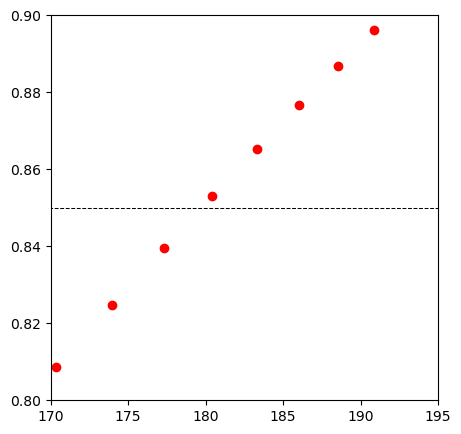

179.7208703057815


In [3]:
def P01(vol, var):
    FA = var[0]
    FB = var[1]
    FC = var[2]
    FT = FA + FB + FC
    
    T  = 573 #K
    P  = 1.0 #atm
    R  = 0.08206 #L*atm/mol/K
    Q  = FT*R*T/P
    
    CA = FA/Q
    CB = FB/Q
    
    r  = k*CA*CB
    
    RA = -6*r
    RB = -19*r
    RC = r
    
    dFAdV = RA
    dFBdV = RB
    dFCdV = RC
    return [dFAdV, dFBdV, dFCdV]

FAf   = 3.7 #mol/h
FBf   = 9.3 #mol/h
FCf   = 0.0 #mol/h
vspan = (0, 200)
var0  = [FAf, FBf, FCf]
ans09 = solve_ivp(P01, vspan, var0, atol = 1e-10, rtol = 1e-10)
V     = ans09.t
FB    = ans09.y[1,:]
XB    = (FBf - FB)/FBf

#plt.figure(1, figsize = (5,5))
#plt.plot(V, FB, 'ro')

plt.figure(1, figsize = (5,5))
plt.plot(V, XB, 'ro')
plt.hlines(0.85, 0, 200, color = 'black', linestyle = 'dashed', linewidth = 0.75)
plt.xlim(170, 195)
plt.ylim(0.8, 0.9)
plt.show(1)
itp1  = interp1d(XB, V)
Vsol  = itp1(0.85)
print(Vsol)

## Example Problem 02

Consider the following liquid-phase, irreversible, homogeneous reaction that is occurring in an isothermal, well-mixed,  batch reactor: 

$$A + B \rightarrow C$$

This reaction is first order in A and first order in B. You may assume that the liquid inside of the reactor has a constant density (it is mostly solvent). Additional data are given below:

\begin{align}
    k &= 0.0975 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
    C_{A0} &= 0.62 \ \textrm{mol} \ \textrm{L}^{-1}\\
    C_{B0} &= 1.35 \ \textrm{mol} \ \textrm{L}^{-1}\\
    V_0 &= 17 \textrm{L}
\end{align}

What fractional conversion of species A is achieved after 16 hours? 	

**Answer**: $X_A = 0.797$

### Solution to Example Problem 02

We start with a balance on Species A in a well-mixed batch reactor:

$$\frac{dN_A}{dt} = R_AV$$

We define $R_A$ as usual:

$$R_A = \sum_{i = 1}^{N_R} \nu_{i,A} \, r_i$$

We again have a single reaction, so:

$$R_A = -r$$

The problem statement tells us that the reaction is first order in A and first order in B, so:

$$r = kC_AC_B$$

Then:

$$R_A = -kC_AC_B$$

We substitute this into the material balance to get:

$$\frac{dN_A}{dt} = -kC_AC_BV$$

We encounter the usual situation where we have a single ODE in 1 independent variable (time) and 3 dependent variables (NA, CA, CB).  We *can* use the approaches from lecture 14 and 15 to obtain a hand solution for this problem. That is, we can express NA, CA, and CB all as functions of fractional conversion.  But I am going to choose to solve it by writing balances on any species I need to keep track of.  Here, we only need to keep track of A and B.  Volume is constant, so the concentrations of species only depend on the number of moles of A and B in the system at any point in time.

With this approach in mind, we write balances on A and B:

\begin{align}
    \frac{dN_A}{dt} = R_AV \\
    \frac{dN_B}{dt} = R_BV \\
\end{align}

Now I just make sure I define everything on the right hand side of those balance equations in terms of NA, NB, and/or t.  If I can do that, I can solve the problem.

First, the production rates:

\begin{align}
    R_A = -r \\
    R_B = -r \\
\end{align}

The rate expression:

$$r = kC_AC_B$$

Now the concentrations:

\begin{align}
    C_A = N_A/V \\
    C_B = N_B/V \\
\end{align}

In this case, volume is constant at 17L, so we have basically solved the problem.  All we need to do is write up these equations as a function that we can integrate with solve_ivp.

In [4]:
def P02(t, var):
    k  = 0.0975 #L/mol/h
    V  = 17.0   #L
    
    NA = var[0]
    NB = var[1]
    
    CA = NA/V
    CB = NB/V
    
    r  = k*CA*CB
    
    RA = -r
    RB = -r
    
    dNAdt = RA*V
    dNBdt = RB*V
    return [dNAdt, dNBdt]

In [5]:
V0  = 17.0 #L
CA0 = 0.62 #mol/L
CB0 = 1.35 #mol/L
NA0 = CA0*V0 #mol
NB0 = CB0*V0 #mol

tspan = (0.0, 16.0)
var0  = [NA0, NB0]
ans07 = solve_ivp(P02, tspan, var0, atol = 1e-10, rtol = 1e-10)
NA    = ans07.y[0,:]
XA    = (NA0 - NA)/NA0
print(XA[-1])

0.7970008948936592
